# kidGAN: visualizing your baby's face

This project originates from a personal experience of mine - me and my wife are recently ready to welcome a young new life, and we cannot wait to see our baby. However, as we search online for a reliable deep learning-based tool to predict our baby's look, surprisingly there has not been any reliable one available at all - many are simply blending/averaging pictures of me and my wife that we uploaded and do not produce good results. So - "If you want something done right, do it yourself"? 

Technically, projects as such, where we aim at training a model for identification of common features between parents and children (or more broadly, between relatives), are collectively termed automatic kinship recognition. It has a variety of applications, e.g. forensic investigations, automatic photo library management, historic lineage & genealogical studies, social-media-based analysis, and even cases of missing children and human trafficking (check out [this link](https://competitions.codalab.org/competitions/22117)). However, we are not satisfied with only correctly identifying the kinship, but we want the model to **"improvise" produce new images based on some inputs**. Whenever generation is part of the goal, we should definitely consider applying **Generative Adversarial Networks (GANs)**, in our case the recent **StyleGAN2**. But in this notebook, we only focus on exploring the data we are going to use first. 

## EDA

Several public kinship recognition datasets available:

- [Families in the Wild (FIW)/Reconizing Families in the Wild (RFIW)](https://web.northeastern.edu/smilelab/fiw/index.html). 11,932 natural family photos of 1,000 families, with 656,954 image pairs split between the 11 relationship. Also, we have this [Kaggle Competition here](https://www.kaggle.com/c/recognizing-faces-in-the-wild/data) that deposits the same data.

- [TSKinface](http://parnec.nuaa.edu.cn/xtan/data/TSKinFace.html), contains 1,500 pictures of father, mother and child. The link to the original dataset is down and I downloaded [here](https://github.com/mingu600/childGAN).

- [KinFaceW](https://www.kinfacew.com/datasets.html), two kinship datasets: KinFaceW-I and KinFaceW-II. There are four kin relations in two datasets: Father-Son (F-S), Father-Daughter (F-D), Mother-Son (M-S), and Mother-Daughter (M-D). In the KinFaceW-I dataset, there are 156, 134, 116, and 127 pairs of kinship images for these four relations. For the KinFaceW-II dataset, each relation contains 250 pairs of kinship images. 

- [Family101](http://chenlab.ece.cornell.edu/projects/KinshipClassification/index.html), 101 different family with distinct family names, including 206 nuclear families, 607 individuals, with 14,816 images. 

For this EDA we will use **(recognizing) families in the wild dataset**, as it is the largest dataset available. Later, we will find a way to integrate all these available datasets to make the largest dataset possible in this domain when we actually work on this project. As of now, we will perform some preliminary analyses based on the FIW data to demonstrate that this project is viable, and of course, fun.

In [23]:
import os
import numpy as np
import pandas as pd

# image
import cv2
from PIL import Image
from imageio import imread
from skimage.transform import resize

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# others
from tqdm import tqdm

TODO:
- enhance image resolution
- baby gender

In [13]:
data_dir = 'RFIW2020/'

In [14]:
train_df = pd.read_csv(data_dir+'train_triplets.csv')
val_df = pd.read_csv(data_dir+'val_triples_competition_with_label.csv')

In [5]:
val_df.head()

,F,M,C,tag,label
0,F0290/MID5/P03086_face7.jpg,F0290/MID1/P03087_face0.jpg,F0652/MID1/P03819_face3.jpg,FMS,0
1,F0879/MID2/P09279_face0.jpg,F0879/MID1/P09279_face3.jpg,F0879/MID5/P09276_face4.jpg,FMS,1
2,F0907/MID1/P09577_face4.jpg,F0907/MID2/P09581_face1.jpg,F0907/MID3/P09583_face2.jpg,FMD,1
3,F0705/MID4/P07383_face0.jpg,F0705/MID3/P07383_face2.jpg,F0530/MID3/P05569_face1.jpg,FMS,0
4,F0167/MID1/P01793_face1.jpg,F0167/MID2/P01792_face2.jpg,F0167/MID3/P01795_face1.jpg,FMD,1


### T-SNE visualization of families

In [8]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras_vggface.vggface import VGGFace

model = VGGFace(include_top=False, input_shape=(160, 160, 3), pooling='avg')

58916864/58909280 [==============================] - 81s 1us/step


In [9]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Incorrect dimension!')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def load_and_align_images(filepaths, margin,image_size = 160):
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        aligned = resize(img, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [20]:
def compute_embedding(paths, margin=10, batch_size=512):
    preds = []
    for start in tqdm(range(0, len(paths), batch_size)):
        aligned_images = prewhiten(load_and_align_images(paths[start:start+batch_size], margin))
        preds.append(model.predict_on_batch(aligned_images))
    embeddings = l2_normalize(np.concatenate(preds))

    return embeddings

In [30]:
val_df_pos = val_df[val_df['label'] == 1].reset_index()

test_images_pos_f = val_df_pos['F'].tolist() 
test_images_pos_m = val_df_pos['M'].tolist() 
test_images_pos_c = val_df_pos['C'].tolist() 

test_embs_pos_f = compute_embedding([os.path.join(data_dir+"val-faces/val-faces", f) for f in test_images_pos_f])
test_embs_pos_m = compute_embedding([os.path.join(data_dir+"val-faces/val-faces", f) for f in test_images_pos_m])
test_embs_pos_c = compute_embedding([os.path.join(data_dir+"val-faces/val-faces", f) for f in test_images_pos_c])


In [26]:
test_embs_pos_f.shape

(1784, 512)

In [86]:
np.random.seed(123)
pos_tsne_idx = np.random.choice(val_df_pos.index, 100)
val_pos_tsne = val_df_pos.iloc[pos_tsne_idx][['F','M','C']]

In [87]:
val_pos_tsne['family'] = val_pos_tsne.index

In [88]:
val_pos_tsne = pd.melt(val_pos_tsne, id_vars='family')

In [89]:
test_embs_pos = np.concatenate([test_embs_pos_f[pos_tsne_idx],
                                test_embs_pos_m[pos_tsne_idx],
                                test_embs_pos_c[pos_tsne_idx]])

In [90]:
def tsne_viz_family(inputprob, n, obj_classes):
    
    """Wrapper for t-SNE visualization.
    t-SNE visualization as described in:
      L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. 
      Journal of Machine Learning Research 9(Nov):2579-2605, 2008.
    
    Arguments:
        inputprob {np.array} -- predictions by model.
        n {int} -- top number of examples to include.
        obj_classes {list} -- list of class labels.
   
    """
    import sklearn.manifold, matplotlib.cm as cm
    predictions = inputprob
    colors = iter(cm.rainbow(np.linspace(0, 1, len(obj_classes))))
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(predictions[:n])
    
    plt.figure(figsize=(9, 7), dpi=100)
    for d in range(len(obj_classes)):
        xx = X_embedded[[d, d+len(obj_classes), d+2*len(obj_classes)], 0]
        yy = X_embedded[[d, d+len(obj_classes), d+2*len(obj_classes)], 1]
        plt.scatter(xx, yy, c=[next(colors)], label='family_'+str(obj_classes[d]))
        
#     plt.legend()   
    plt.show()

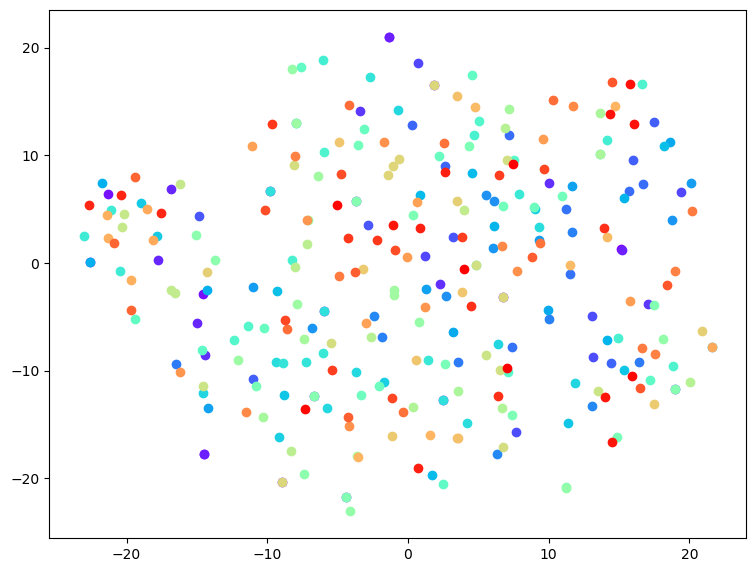

In [91]:
tsne_viz_family(test_embs_pos, 
         300,
         pos_tsne_idx
        )

We can see that the members of individual families **do not automatically cluster well** and clearly visualized on 2D manifold extracted by T-SNE, which indicates that **the embeddings extracted are far from perfect** (which makes intuitive sense, since we used pretrained model and did not actually perform training yet). Also, it indicates the **kinship features between family members are intricate and difficult to extract**.

In [103]:
def tsne_viz_role(inputprob, n, obj_classes):
    
    """Wrapper for t-SNE visualization.
    t-SNE visualization as described in:
      L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. 
      Journal of Machine Learning Research 9(Nov):2579-2605, 2008.
    
    Arguments:
        inputprob {np.array} -- predictions by model.
        n {int} -- top number of examples to include.
        obj_classes {list} -- list of class labels.
   
    """
    import sklearn.manifold, matplotlib.cm as cm
    predictions = inputprob
    colors = iter(cm.rainbow(np.linspace(0, 1, len(obj_classes))))
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(predictions[:n])
    
    plt.figure(figsize=(9, 7), dpi=100)
    for d in range(len(obj_classes)):
        xx = X_embedded[(d*n//len(obj_classes)):((d+1)*n//len(obj_classes)), 0]
        yy = X_embedded[(d*n//len(obj_classes)):((d+1)*n//len(obj_classes)), 1]
        plt.scatter(xx, yy, c=[next(colors)], label=obj_classes[d])
    plt.legend()   
    plt.show()

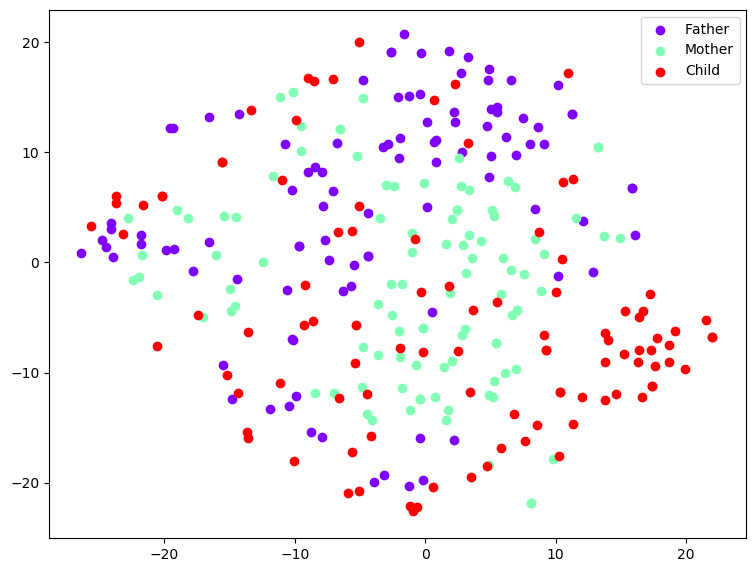

In [104]:
tsne_viz_role(test_embs_pos, 
         300,
         ['Father', 'Mother', 'Child']
        )

However, the example points are relatively better separated using gender/role, meaning that the pretrained model have learned to roughly classify faces based on age and gender. We will need to re-train and tune it so as to force it to learn more underlying features.

### Compute distances between parents and children

In [105]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [119]:
# father and child
cos_sim_f_c = np.diag(cosine_similarity(test_embs_pos_f, test_embs_pos_c))
euc_dist_f_c = np.diag(euclidean_distances(test_embs_pos_f, test_embs_pos_c))

# mother and child
cos_sim_m_c = np.diag(cosine_similarity(test_embs_pos_m, test_embs_pos_c))
euc_dist_m_c = np.diag(euclidean_distances(test_embs_pos_m, test_embs_pos_c))

# average between father and mother, and child
test_embs_pos_avg = (test_embs_pos_f + test_embs_pos_m)/2.0
cos_sim_avg_c = np.diag(cosine_similarity(test_embs_pos_avg, test_embs_pos_c))
euc_dist_avg_c = np.diag(euclidean_distances(test_embs_pos_avg, test_embs_pos_c))

In [121]:
cos_sim_f_c

array([0.45661637, 0.5010126 , 0.44330335, ..., 0.511109  , 0.4869696 ,
       0.49155363], dtype=float32)

In [120]:
cos_sim_m_c

array([0.5892205 , 0.45454806, 0.5915159 , ..., 0.49587947, 0.5765197 ,
       0.55275285], dtype=float32)

In [122]:
cos_sim_avg_c

array([0.62949634, 0.5476906 , 0.6080594 , ..., 0.5559408 , 0.5801563 ,
       0.62034136], dtype=float32)

In [126]:
import plotly.express as px
cos_sims = pd.DataFrame({'Father-Child': cos_sim_f_c,
                         'Mother-Child': cos_sim_m_c,
                         'Average-Child': cos_sim_avg_c})
cos_sims = pd.melt(cos_sims)
cos_sims.columns = ['relationship','similarity']

fig = px.box(cos_sims, 
             x="relationship", 
             y="similarity", 
             color = "relationship",
             points="all")
fig.show()

In [127]:
euc_dists = pd.DataFrame({'Father-Child': euc_dist_f_c,
                         'Mother-Child': euc_dist_m_c,
                         'Average-Child': euc_dist_avg_c})
euc_dists = pd.melt(euc_dists)
euc_dists.columns = ['relationship','distance']

fig = px.box(euc_dists, 
             x="relationship", 
             y="distance", 
             color = "relationship",
             points="all")
fig.show()

We can see that averaging the embeddings of father and mother greatly improves similarity to embeddings of child (and lowers the distances), which agrees with our intuition. In the actual model training, we will also be **averaging the latent embeddings from each parent in order to derive a common representation for embedding of child**.

### Correlations between similarities/distances

Finally, let's look at the correlation matrices between the similarities/distances:

In [131]:
cos_sims = pd.DataFrame({'Father-Child': cos_sim_f_c,
                         'Mother-Child': cos_sim_m_c,
                         'Average-Child': cos_sim_avg_c})
fig = px.scatter_matrix(cos_sims)
fig.update_traces(diagonal_visible=False)
fig.show()

In [130]:
euc_dists = pd.DataFrame({'Father-Child': euc_dist_f_c,
                         'Mother-Child': euc_dist_m_c,
                         'Average-Child': euc_dist_avg_c})
fig = px.scatter_matrix(euc_dists)
fig.update_traces(diagonal_visible=False)
fig.show()

In [133]:
from scipy.stats import pearsonr
print(pearsonr(cos_sim_f_c, cos_sim_m_c))
print(pearsonr(euc_dist_f_c, euc_dist_m_c))

(0.30122664115578013, 9.711335089819445e-39)
(0.28703273289824877, 3.5087818613244876e-35)


We can see that the correlations between father-child similarity and mother-child similarity, as well as father-child distance and mother-child distance are significant. This indicates that indeed features extracted from two parents partially show similarity with child embeddings i.e. a child tends similar to both of his parents simultaneously, which is again intuitive. In summary, the results displayed above shows that this project is an interesting topic to invest time!